Trabajo practico 2 de Vision Trasnformers

Por Carlos Villalobos

1. **Implementar la arquitectura de un Vision Transformer** 

2. **Ingresar y ajustar los parametros del modelo***

3. **Probar diferentes técnicas de data augmentation** 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
#from trainer import Trainer



device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches
    

class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module):
    import torch
from torch import nn
import matplotlib.pyplot as plt
import math

# Configuraciones a probar
configs = [
    {"patch_size": 32, "embed_dim": 16},
    {"patch_size": 64, "embed_dim": 8},
    {"patch_size": 128, "embed_dim": 4}
]

def analyze_config(img_size, patch_size, embed_dim):
    num_patches = (img_size // patch_size) ** 2
    total_params = num_patches * embed_dim
    return {
        "num_patches": num_patches,
        "total_params": total_params,
        "spatial_resolution": patch_size
    }

# Análisis de diferentes configuraciones
img_size = 900
for config in configs:
    analysis = analyze_config(img_size, config["patch_size"], config["embed_dim"])
    print(f"\nConfiguración: Patch Size = {config['patch_size']}, Embed Dim = {config['embed_dim']}")
    print(f"Número de parches: {analysis['num_patches']}")
    print(f"Resolución espacial: {analysis['spatial_resolution']}x{analysis['spatial_resolution']} pixels")
    print(f"Parámetros totales: {analysis['total_params']}")

# Clase PositionalEncoding original
class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pos_embedding', self.create_positional_encoding(num_patches, embed_dim))

    def create_positional_encoding(self, num_patches, embed_dim):
        position = torch.arange(num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pos_encoding = torch.zeros(num_patches, embed_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)  # Aplicar seno en dimensiones pares
        pos_encoding[:, 1::2] = torch.cos(position * div_term)  # Aplicar coseno en dimensiones impares
        return pos_encoding.unsqueeze(0)  # Añadir dimensión de batch

    def forward(self, x):
        return x + self.pos_embedding

# Implementación de la clase PositionalEncodingLearned
class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim) * 0.02)

    def forward(self, x):
        return x + self.pos_embedding

# Función para visualizar y comparar ambos encodings
def compare_positional_encodings(num_patches, embed_dim, device):
    # Inicializar ambos tipos de encoding
    learned_pe = PositionalEncodingLearned(num_patches, embed_dim).to(device)
    sinusoidal_pe = PositionalEncoding(num_patches, embed_dim).to(device)

    # Generar datos de ejemplo
    x = torch.zeros(1, num_patches, embed_dim).to(device)

    # Obtener embeddings
    learned_embeddings = learned_pe(x)
    sinusoidal_embeddings = sinusoidal_pe(x)

    # Visualizar
    plt.figure(figsize=(15, 5))

    # Sinusoidal
    plt.subplot(1, 2, 1)
    for i in range(embed_dim):
        plt.plot(sinusoidal_embeddings[0, :, i].detach().cpu().numpy(),
                label=f'Dim {i+1}')
    plt.title('Codificación Posicional Sinusoidal')
    plt.xlabel('Posición')
    plt.ylabel('Valor')
    plt.legend()

    # Learned
    plt.subplot(1, 2, 2)
    for i in range(embed_dim):
        plt.plot(learned_embeddings[0, :, i].detach().cpu().numpy(),
                label=f'Dim {i+1}')
    plt.title('Codificación Posicional Aprendida')
    plt.xlabel('Posición')
    plt.ylabel('Valor')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Probar con los parámetros originales
img_size = 900
patch_size = 64
embed_dim = 8
num_patches = (img_size // patch_size) ** 2
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

compare_positional_encodings(num_patches, embed_dim, device)



# Parámetros
img_path = "/kaggle/input/raccoon/raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(device,img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional

num_patches = (img_size // patch_size) ** 2
try:
    positional_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
    pos_embeddings = positional_encoding(patches)

except Exception as e:
    print(f"Revise la existencia de la función PositionalEncodingLearned. Se produjo error durante la compilación: \n {e}.")


Vision Trasnformer

In [2]:
import torch
import torch.nn as nn

class VisionTransformer(nn.Module):
    def __init__(self, 
                 img_size: int = 900,
                 patch_size: int = 64,
                 in_channels: int = 3,
                 num_classes: int = 1000,
                 embed_dim: int = 8,
                 num_heads: int = 2,
                 ff_dim: int = 32,
                 num_layers: int = 4,
                 dropout: float = 0.1):
        super().__init__()
        
        # Patch Embedding
        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        
        # Número de parches
        self.num_patches = (img_size // patch_size) ** 2
        
        # [CLS] token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.normal_(self.cls_token, std=0.02)
        
        # Codificación posicional
        self.pos_embed = PositionalEncodingLearned(self.num_patches + 1, embed_dim)
        
        # Dropout
        self.pos_drop = nn.Dropout(p=dropout)
        
        # Transformer Encoder
        self.transformer = TransformerEncoder(
            embed_dim=embed_dim,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_layers=num_layers,
            dropout=dropout
        )
        
        # Layer Norm
        self.norm = nn.LayerNorm(embed_dim)
        
        # Clasificador
        self.head = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        # Crear embeddings de los parches
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)
        
        # Añadir token CLS
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        
        # Añadir codificación posicional
        x = self.pos_embed(x)
        
        # Aplicar dropout
        x = self.pos_drop(x)
        
        # Pasar por el transformer
        x = self.transformer(x)
        
        # Normalización
        x = self.norm(x)
        
        # Clasificación usando solo el token CLS
        x = x[:, 0]
        x = self.head(x)
        
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim debe ser divisible por num_heads"
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Proyecciones lineales para Q, K, V
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Proyectar y reshape para multi-head
        q = self.q_proj(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.k_proj(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.v_proj(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # Calcular scores de atención
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        
        # Aplicar softmax
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        # Aplicar atención a los valores
        x = torch.matmul(attn, v)
        
        # Reshape y proyección final
        x = x.permute(0, 2, 1, 3).reshape(batch_size, seq_len, self.embed_dim)
        x = self.out_proj(x)
        
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout: float = 0.1):
        super().__init__()
        
        # Multi-Head Attention
        self.attention = MultiHeadAttention(embed_dim, num_heads, dropout)
        
        # Feed Forward Network
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
        # Layer Normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        # Atención con residual connection
        x = x + self.attention(self.norm1(x))
        
        # FFN con residual connection
        x = x + self.ffn(self.norm2(x))
        
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout: float = 0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [3]:
# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

100%|██████████| 170498071/170498071 [00:01<00:00, 105511015.14it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Tamaño de carpeta: 340.19 MB


2. 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VisionTransformer(nn.Module):
    def __init__(self, 
                 img_size: int = 32,          # CIFAR-10 image size
                 patch_size: int = 4,          # Smaller patches for small images
                 in_channels: int = 3,
                 num_classes: int = 10,        # CIFAR-10 has 10 classes
                 embed_dim: int = 192,         # Increased embedding dimension
                 num_heads: int = 8,           # More heads for better attention
                 ff_dim: int = 768,           # Larger feed-forward dimension
                 num_layers: int = 7,          # More layers for better feature extraction
                 dropout: float = 0.1):
        super().__init__()
        
        assert img_size % patch_size == 0, "Image size must be divisible by patch size"
        
        # Patch Embedding
        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        
        # Número de parches (64 parches para 32x32 con patch_size=4)
        self.num_patches = (img_size // patch_size) ** 2
        
        # [CLS] token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        # Codificación posicional
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
        # Dropout
        self.pos_drop = nn.Dropout(p=dropout)
        
        # Transformer Encoder
        self.transformer = TransformerEncoder(
            embed_dim=embed_dim,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_layers=num_layers,
            dropout=dropout
        )
        
        # Layer Norm
        self.norm = nn.LayerNorm(embed_dim)
        
        # Clasificador con dropout
        self.pre_head_dropout = nn.Dropout(0.2)
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Inicialización de pesos
        self._init_weights()
        
    def _init_weights(self):
        # Inicialización de la capa de clasificación
        nn.init.zeros_(self.head.bias)
        nn.init.xavier_uniform_(self.head.weight)
        
    def forward(self, x):
        # Crear embeddings de los parches
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)
        
        # Añadir token CLS
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        
        # Añadir codificación posicional
        x = x + self.pos_embed
        
        # Aplicar dropout
        x = self.pos_drop(x)
        
        # Pasar por el transformer
        x = self.transformer(x)
        
        # Normalización
        x = self.norm(x)
        
        # Clasificación usando solo el token CLS con dropout adicional
        x = x[:, 0]
        x = self.pre_head_dropout(x)
        x = self.head(x)
        
        return x

# Función de entrenamiento y evaluación
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Batch: {batch_idx}, Loss: {loss.item():.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')
    
    return total_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    return test_loss / len(test_loader), 100. * correct / total

# Configuración del modelo y entrenamiento
def setup_training():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_epochs = 10
    # Inicializar modelo
    model = VisionTransformer(
        img_size=32,          # CIFAR-10 image size
        patch_size=4,         # 4x4 patches
        in_channels=3,
        num_classes=10,
        embed_dim=192,        # Embedding dimension
        num_heads=8,          # Number of attention heads
        ff_dim=768,          # Feed-forward dimension
        num_layers=7,         # Number of transformer layers
        dropout=0.1
    ).to(device)
    
    # Criterio y optimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), 
                           lr=1e-3, 
                           weight_decay=0.05,
                           betas=(0.9, 0.999))
    
    # Learning rate scheduler
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    
    return model, criterion, optimizer, scheduler, device

# Uso del modelo
model, criterion, optimizer, scheduler, device = setup_training()
print(f"Modelo creado en dispositivo: {device}")

Modelo creado en dispositivo: cuda


In [5]:
print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model = model.to(device)


try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

Parametros del modelo: [Parameter containing:
tensor([[[ 0.0271, -0.0157,  0.0161,  0.0147, -0.0008, -0.0447, -0.0281,
          -0.0166, -0.0087, -0.0048,  0.0098,  0.0107, -0.0171, -0.0110,
          -0.0006, -0.0242,  0.0112,  0.0422, -0.0211, -0.0024, -0.0458,
           0.0407,  0.0158,  0.0018,  0.0013,  0.0235, -0.0013,  0.0263,
           0.0114,  0.0292, -0.0283,  0.0285,  0.0134, -0.0318,  0.0200,
           0.0288,  0.0027,  0.0145,  0.0101, -0.0089,  0.0270, -0.0019,
          -0.0186, -0.0150, -0.0210,  0.0089, -0.0309, -0.0055, -0.0195,
          -0.0100,  0.0033,  0.0124,  0.0196, -0.0051, -0.0105, -0.0198,
           0.0065, -0.0180, -0.0073,  0.0125, -0.0269,  0.0417, -0.0133,
          -0.0060, -0.0232, -0.0029, -0.0056,  0.0201,  0.0038,  0.0019,
          -0.0235, -0.0233, -0.0509, -0.0064, -0.0071,  0.0302, -0.0107,
          -0.0070, -0.0017, -0.0122,  0.0045,  0.0020, -0.0021,  0.0112,
           0.0024,  0.0164,  0.0054,  0.0357, -0.0178, -0.0133, -0.0013,
     

In [6]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))

Número de parámetros: 3.13 millones


In [7]:
# Número de épocas
num_epochs = 10

# Listas para tracking
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    print(f'\nEpoch: {epoch+1}/{num_epochs}')
    
    # Entrenamiento
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluación
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Actualizar learning rate
    scheduler.step()
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


Epoch: 1/10


W1029 23:07:44.626000 138405542786880 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_30/2056583351.py line 66 
W1029 23:07:44.626000 138405542786880 torch/_dynamo/convert_frame.py:1009] due to: 
W1029 23:07:44.626000 138405542786880 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1029 23:07:44.626000 138405542786880 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1029 23:07:44.626000 138405542786880 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1029 23:07:44.626000 138405542786880 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1029 23:07:44.626000 138405542786880 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1029 23:07:44.626000 138405542786880 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.1

Batch: 0, Loss: 3.0283, Acc: 10.74%
Train Loss: 2.1661, Train Acc: 23.47%
Test Loss: 1.7969, Test Acc: 33.54%

Epoch: 2/10
Batch: 0, Loss: 1.9416, Acc: 30.47%
Train Loss: 1.7730, Train Acc: 34.12%
Test Loss: 1.5772, Test Acc: 42.72%

Epoch: 3/10
Batch: 0, Loss: 1.7147, Acc: 37.70%
Train Loss: 1.6003, Train Acc: 41.11%
Test Loss: 1.5090, Test Acc: 44.68%

Epoch: 4/10
Batch: 0, Loss: 1.5524, Acc: 45.70%
Train Loss: 1.5597, Train Acc: 42.80%
Test Loss: 1.4870, Test Acc: 45.43%

Epoch: 5/10
Batch: 0, Loss: 1.6022, Acc: 41.02%
Train Loss: 1.5368, Train Acc: 43.80%
Test Loss: 1.4673, Test Acc: 46.48%

Epoch: 6/10
Batch: 0, Loss: 1.5934, Acc: 43.95%
Train Loss: 1.5319, Train Acc: 43.97%
Test Loss: 1.4626, Test Acc: 46.32%

Epoch: 7/10
Batch: 0, Loss: 1.5428, Acc: 41.99%
Train Loss: 1.5308, Train Acc: 43.93%
Test Loss: 1.4621, Test Acc: 46.87%

Epoch: 8/10
Batch: 0, Loss: 1.4942, Acc: 43.95%
Train Loss: 1.5306, Train Acc: 44.01%
Test Loss: 1.4689, Test Acc: 46.79%

Epoch: 9/10
Batch: 0, Loss: 

In [8]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return accuracy, precision, recall, f1

# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)


100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


In [9]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.47
Precision: 0.46
Recall: 0.47
F1 score: 0.46


In [10]:
train_dataset.data[0].shape

(32, 32, 3)

3.

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


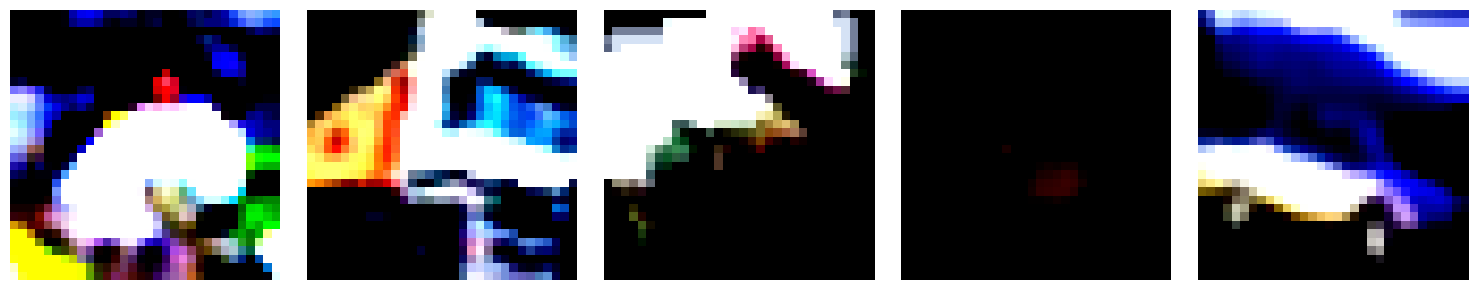


Epoch: 1/10
Batch: 0, Loss: 3.4044, Acc: 9.18%
Train Loss: 2.4098, Train Acc: 13.43%
Test Loss: 1.9440, Test Acc: 28.56%

Epoch: 2/10
Batch: 0, Loss: 2.1164, Acc: 9.96%
Train Loss: 2.0728, Train Acc: 16.26%
Test Loss: 1.7993, Test Acc: 33.44%

Epoch: 3/10
Batch: 0, Loss: 1.9857, Acc: 29.10%
Train Loss: 1.9582, Train Acc: 19.38%
Test Loss: 1.7171, Test Acc: 37.73%

Epoch: 4/10
Batch: 0, Loss: 1.9987, Acc: 30.86%
Train Loss: 1.8684, Train Acc: 21.17%
Test Loss: 1.5756, Test Acc: 43.44%

Epoch: 5/10
Batch: 0, Loss: 2.1619, Acc: 15.62%
Train Loss: 1.8177, Train Acc: 24.57%
Test Loss: 1.4811, Test Acc: 47.35%

Epoch: 6/10
Batch: 0, Loss: 1.9325, Acc: 39.06%
Train Loss: 1.7659, Train Acc: 26.44%
Test Loss: 1.4776, Test Acc: 46.84%

Epoch: 7/10
Batch: 0, Loss: 1.5496, Acc: 43.16%
Train Loss: 1.7146, Train Acc: 28.35%
Test Loss: 1.4244, Test Acc: 49.78%

Epoch: 8/10
Batch: 0, Loss: 2.0122, Acc: 17.97%
Train Loss: 1.7606, Train Acc: 24.77%
Test Loss: 1.3841, Test Acc: 49.73%

Epoch: 9/10
Batch

In [11]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import random
import numpy as np

class CustomGaussianBlur:
    def __init__(self, kernel_size, sigma_min=0.1, sigma_max=2.0):
        self.kernel_size = kernel_size
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max

    def __call__(self, img):
        sigma = random.uniform(self.sigma_min, self.sigma_max)
        return TF.gaussian_blur(img, self.kernel_size, [sigma, sigma])

class RandAugment:
    """Implementación simplificada de RandAugment"""
    def __init__(self, n=2, m=9):
        self.n = n  # número de transformaciones a aplicar
        self.m = m  # magnitud de las transformaciones
        
        # Lista de posibles transformaciones
        self.transforms = [
            transforms.RandomRotation(degrees=(-20, 20)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            CustomGaussianBlur(kernel_size=3),
            transforms.RandomAdjustSharpness(sharpness_factor=2),
            transforms.RandomAutocontrast(),
            transforms.RandomEqualize(),
        ]

    def __call__(self, img):
        transforms_to_apply = random.choices(self.transforms, k=self.n)
        for transform in transforms_to_apply:
            img = transform(img)
        return img

# Definir las transformaciones de entrenamiento con aumentación de datos
train_transform = transforms.Compose([
    # Transformaciones espaciales
    transforms.RandomResizedCrop(
        size=(32, 32),
        scale=(0.8, 1.0),    # rango de escala
        ratio=(0.9, 1.1)     # rango de ratio
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=(-15, 15)),
    
    # Transformaciones de color y ruido
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    CustomGaussianBlur(
        kernel_size=3,
        sigma_min=0.1,
        sigma_max=2.0
    ),
    
    # RandAugment para transformaciones adicionales
    RandAugment(n=2, m=9),
    
    # Normalización final
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.49139968, 0.48215841, 0.44653091],
        std=[0.24703223, 0.24348513, 0.26158784]
    ),
])

# Transformaciones para validación/prueba (sin aumentación)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.49139968, 0.48215841, 0.44653091],
        std=[0.24703223, 0.24348513, 0.26158784]
    ),
])

# Cargar los datasets con las nuevas transformaciones
def load_datasets(batch_size=512):
    train_dataset = datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=train_transform
    )
    
    test_dataset = datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=test_transform
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    return train_loader, test_loader

# Función para visualizar las transformaciones
def visualize_augmentations(dataset, num_examples=5):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 3))
    for i in range(num_examples):
        img, _ = dataset[i]
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(img.permute(1, 2, 0).clip(0, 1))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Función de entrenamiento modificada para usar mixup
def mixup_data(x, y, alpha=0.2):
    """Realiza mixup en los datos de entrada"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Calcula la pérdida para datos con mixup"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Función de entrenamiento modificada
def train_epoch_with_augmentation(model, train_loader, criterion, optimizer, device, use_mixup=True):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        if use_mixup:
            data, target_a, target_b, lam = mixup_data(data, target)
        
        optimizer.zero_grad()
        output = model(data)
        
        if use_mixup:
            loss = mixup_criterion(criterion, output, target_a, target_b, lam)
        else:
            loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calcular precisión (sin mixup para simplicidad)
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Batch: {batch_idx}, Loss: {loss.item():.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')
    
    return total_loss / len(train_loader), 100. * correct / total

# Ejemplo de uso
if __name__ == "__main__":
    # Cargar datos con las nuevas transformaciones
    train_loader, test_loader = load_datasets(batch_size=512)
    
    # Visualizar ejemplos de aumentación
    train_dataset = datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=train_transform
    )
    visualize_augmentations(train_dataset)
    
    # Configurar el modelo y entrenamiento
    model, criterion, optimizer, scheduler, device = setup_training()
    
    # Entrenar con las nuevas técnicas de aumentación
    num_epochs = 10
    for epoch in range(num_epochs):
        print(f'\nEpoch: {epoch+1}/{num_epochs}')
        
        train_loss, train_acc = train_epoch_with_augmentation(
            model, train_loader, criterion, optimizer, device, use_mixup=True
        )
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        scheduler.step()
        
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')